# Business Proposal

Business problem: What are the best 5 zip codes to invest in?

Business - A real estate investment firm looking to acquire new property to invest in.

Focus - Investing in real estate for high growth zip codes.

Narrowing down zip codes - Look to see where everyone is trying to move to. Find the 25 highest historic ROI zipcodes from the past 10 years. Run a model for all 25 and then pick the best 5 zipcodes with the highest ROI.

Chosen State: Idaho
 - Based off of Census and other surveys deciding to go with Idaho.

Ways to narrow down zipcodes
 - looking at the historic 5 year ROI
 - Narrowing down to the best 25 zip codes
 - Doing a time series on all 25

# Loading all necessary packages and loading data file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.utils import tsdisplay




%matplotlib inline

from matplotlib import rcParams
plt.style.use('seaborn')
rcParams['figure.figsize']=(12,8)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
data = pd.read_csv("Data/zillow_data.csv")

# EDA

In [3]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [4]:
data.tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,92600.0,92600.0,92800.0,93100.0,93500.0,94000.0,94500.0,95100.0,95800.0,96500.0,97100.0,97800.0,98500.0,99200.0,100000.0,100800.0,101700.0,102600.0,103400.0,104200.0,104900.0,105600.0,106300.0,106800.0,107300.0,107800.0,108400.0,109000.0,109600.0,110200.0,110800.0,111400.0,112000.0,112600.0,113000.0,113500.0,113900.0,114300.0,114800.0,115400.0,116000.0,116700.0,117400.0,118100.0,118700.0,119500.0,120100.0,120600.0,121100.0,121700.0,122400.0,123300.0,124200.0,125300.0,126300.0,127400.0,128500.0,129600.0,130600.0,131400.0,132100.0,133000.0,133900.0,134900.0,136000.0,137200.0,138500.0,139700.0,140900.0,141900.0,143600.0,146300.0,149100.0,150900.0,151800.0,152000.0,151700.0,151700.0,152500.0,154200.0,156700.0,159800.0,163000.0,166000.0,168700.0,171400.0,174100.0,176800.0,179200.0,180800.0,181800.0,182400.0,182800.0,183200.0,183700.0,184300.0,185400.0,187300.0,190000.0,193400.0,197200.0,200600.0,203100.0,204400.0,205000.0,205300.0,205400.0,205500.0,205300.0,205100.0,204800.0,204800.0,204900.0,205200.0,205700.0,206200.0,206500.0,206500.0,206300.0,206100.0,205900.0,205600.0,205000.0,204100.0,202900.0,201600.0,200200.0,198900.0,197800.0,197100.0,196900.0,197300.0,197900.0,198100.0,197800.0,197200.0,196400.0,195600.0,194600.0,193400.0,192200.0,191300.0,190800.0,190700.0,190500.0,189800.0,188700.0,187500.0,186700.0,186600.0,187100.0,187300.0,187500.0,187700.0,188200.0,189000.0,190100.0,190200.0,188500.0,186200.0,184400.0,184400.0,185900.0,188000.0,188900.0,188900.0,187600.0,183700.0,177100.0,173200.0,173000.0,174700.0,176200.0,176300.0,174700.0,174000.0,174800.0,175800.0,175500.0,174600.0,174700.0,175200.0,175400.0,175200.0,175300.0,174500.0,173100.0,172700.0,1732

In [5]:
data.shape

(14723, 272)

## General info about the dataset

In [6]:
print('The data has {} number of entries. The number of unique RegionNames is {}.'.format(data.shape[0],data['RegionName'].nunique()))
print('So there seems to be no duplicate entries.')

The data has 14723 number of entries. The number of unique RegionNames is 14723.
So there seems to be no duplicate entries.


In [7]:
print('This dataset looks at {} different "states" (includes DC).'.format(data['State'].nunique()))

This dataset looks at 51 different "states" (includes DC).


In [8]:
print('This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.')

This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.


## Looking at missing values in the dataframe

In [9]:
#Seeing how many na values are in the dataset
print('There are {} Nan values in the dataset.'.format(data.isna().sum().sum()))

There are 157934 Nan values in the dataset.


In [10]:
#Checking to see what columns have na values.
column_names = data.columns
na_columns = []
for name in column_names:
    NumberOfNa = 0
    NumberOfNa = data[name].isna().sum()
    if NumberOfNa > 0:
        na_columns.append(name)
print('There are {} columns that have na values.'.format(len(na_columns)))
print('Only identifier column with na is "Metro", the others are missing values for dates')

There are 220 columns that have na values.
Only identifier column with na is "Metro", the others are missing values for dates


In [11]:
#Looking at the entries with Nan values for Metro
len(data.loc[lambda x: x.Metro.isna()])
data.loc[lambda x: x.Metro.isna()].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
151,69340,27410,Greensboro,NC,NaN,Guilford,152,137100.0,136600.0,136000.0,135600.0,135300.0,135100.0,135200.0,135600.0,136100.0,136700.0,137500.0,138300.0,139000.0,139600.0,140000.0,140200.0,140400.0,140400.0,140400.0,140400.0,140400.0,140400.0,140600.0,141000.0,141600.0,142500.0,143700.0,145000.0,146400.0,147600.0,148800.0,149700.0,150500.0,150900.0,151300.0,151500.0,151600.0,151800.0,152100.0,152400.0,152900.0,153400.0,154000.0,154600.0,155300.0,156000.0,156700.0,157500.0,158400.0,159100.0,159900.0,160400.0,160900.0,161200.0,161400.0,161400.0,161300.0,161000.0,160800.0,160500.0,160300.0,160000.0,159800.0,159800.0,159900.0,160100.0,160400.0,160700.0,161200.0,161700.0,162200.0,162900.0,163700.0,164500.0,165200.0,165900.0,166400.0,166900.0,167400.0,167800.0,168300.0,168700.0,169000.0,169200.0,169500.0,169700.0,170000.0,170400.0,170700.0,171100.0,171400.0,171900.0,172400.0,173000.0,173600.0,174200.0,174800.0,175300.0,175900.0,176500.0,177200.0,178000.0,178600.0,179100.0,179500.0,179800.0,180100.0,180300.0,180600.0,180800.0,181100.0,181500.0,181700.0,182000.0,182400.0,182800.0,183200.0,183700.0,184300.0,185100.0,185900.0,186700.0,187400.0,188100.0,188600.0,189100.0,189700.0,190300.0,191100.0,192100.0,193000.0,193900.0,194700.0,195400.0,195800.0,196000.0,196000.0,196100.0,196200.0,196200.0,196200.0,196000.0,195600.0,195100.0,194400.0,193800.0,193100.0,192300.0,191700.0,191300.0,190900.0,190400.0,190000.0,189700.0,189400.0,189100.0,188700.0,188200.0,187700.0,187400.0,187200.0,187100.0,186700.0,186100.0,185600.0,184900.0,184800.0,184400.0,183400.0,182400.0,182300.0,182000.0,181600.0,181100.0,180900.0,180600.0,180400.0,180200.0,179800.0,179800.0,180200.0,180100.0,179500.0,179100.0,178900.0,178500.0,178000.0,177700.0,177400.0,177100.0,176800.0,176600.0,176700.0,177300.0,178200.0,179200.0,179300.0,17

In [12]:
# We can drop all the identifiers besides State, City and RegionName (Zipcode)
data_ZipcodeID = data.drop(['RegionID', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [13]:
# Creating a Dataframe with all entries that have any NA values
null_data = data_ZipcodeID[data_ZipcodeID.isnull().any(axis=1)]
print(len(null_data))
null_data.head()

1039


,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,10011,New York,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3762100.0,3908800.0,4023200.0,4084800.0,4080800.0,4037400.0,4002300.0,4005300.0,4045100.0,4107700.0,4191200.0,4303900.0,4436300.0,4557300.0,4640100.0,4661400.0,4611100.0,4513000.0,4400600.0,4302700.0,4249100.0,4264800.0,4353300.0,4493200.0,4635000.0,4741700.0,4826000.0,4898000.0,4938400.0,4960300.0,5016400.0,5131200.0,5271900.0,5397300.0,5502400.0,5602000.0,5686800.0,5729600.0,5745800.0,5749900.0,5723500.0,5671500.0,5666900.0,5734700.0,5824300.0,5897600.0,5968500.0,6068200.0,6189600.0,6305600.0,6421200.0,6550900.0,6662700.0,6719200.0,6726100.0,6716600.0,6706900.0,6711300.0,6730200.0,6777200.0,6785500.0,6811100.0,6722700.0,6578200.0,6555400.0,6647400.0,6725000.0,6783400.0,6789200.0,6823100.0,6892500.0,6786000.0,6560600.0,6403400.0,6377300.0,6398000.0,6458000.0,6613600.0,6727900.0,6692400.0,6710100.0,6859800.0,6934100.0,6936700.0,7103800.0,7428300.0,7694600.0,7872000.0,7994800.0,8003300.0,7972900.0,7962600.0,7908600.0,7720400.0,7704700.0,7819500.0,7886000.0,7814000.0,7849900.0,7864300.0,7818000.0,7799300.0,7796000.0,7798300.0,7927500.0,8152300.0,8289100.0,8554800.0,8835500.0,9015500.0,9245400.0,9591500.0,9817900.0,9817300.0,9919200,10169600,10399000,10440400,10452500,10428700,10476500,10544400,10569300,10572500,10569500,10674900,10848100,11131200,11342700,11378800,11255300,11248600,11286600,11395300,11498100,11574100,11618900,11681200,11701600,11733900,11764800,11830000,11932900,12000400,1199880

A lot of the Nan values seem to be coming from possible newer properties that have been built.

In [14]:
print('The newest zipcode property, aka the last timestamp that has any nan value is {}.'.format(
    null_data.columns[null_data.isnull().any()][-1]))

The newest zipcode property, aka the last timestamp that has any nan value is 2014-06.


## Lets narrow the dataset to just Idaho before continuing on EDA

In [15]:
# Creating Idaho dataframe
Idaho = data_ZipcodeID[data_ZipcodeID['State'] == 'ID']
Idaho.head()

,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
448,83301,Twin Falls,ID,94100.0,94100.0,94200.0,94200.0,94300.0,94400.0,94700.0,95200.0,96000.0,97000.0,98400.0,99900.0,101600.0,103200.0,104600.0,105700.0,106500.0,106900.0,106900.0,106500.0,105600.0,104600.0,103500.0,102600.0,101800.0,101400.0,101300.0,101300.0,101600.0,101900.0,102200.0,102500.0,102700.0,103000.0,103200.0,103200.0,103100.0,102900.0,102600.0,102400.0,102300.0,102400.0,102600.0,103000.0,103500.0,104000.0,104700.0,105400.0,106100.0,106900.0,107700.0,108500.0,109300.0,110200.0,111000.0,111700.0,112400.0,112900.0,113300.0,113400.0,113200.0,112600.0,111700.0,110700.0,109700.0,108800.0,108100.0,107800.0,107700.0,107700.0,107900.0,108200.0,108600.0,109000.0,109400.0,109900.0,110300.0,110500.0,110800.0,111000.0,111200.0,111400.0,111600.0,111900.0,112300.0,112700.0,113100.0,113400.0,113700.0,114000.0,114400.0,114700.0,115200.0,115800.0,116600.0,117400.0,118500.0,119700.0,121100.0,122400.0,123600.0,124800.0,125800.0,126700.0,127500.0,128100.0,128500.0,128700.0,128700.0,128700.0,128800.0,129200.0,129800.0,130500.0,131000.0,131500.0,131900.0,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,

In [16]:
# Creating a Dataframe with all entries that have any NA values for Idaho
Idaho_null = Idaho[Idaho.isnull().any(axis=1)]
print('There are {} zip codes on record for Idaho.'.format(len(Idaho)))
print('There are {} zip codes that have missing entries'.format(len(Idaho_null)))
Idaho_null.head()

There are 110 zip codes on record for Idaho.
There are 15 zip codes that have missing entries


,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
7742,83333,Hailey,ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353400.0,366700.0,378400.0,388700.0,397100.0,402700.0,404800.0,403900.0,402200.0,401700.0,402600.0,404800.0,408100.0,411700.0,415500.0,418900.0,421100.0,421700.0,420500.0,417700.0,415500.0,414800.0,414500.0,414500.0,414900.0,415500.0,416500.0,418000.0,419200.0,419600.0,417800.0,413300.0,408300.0,403900.0,399200.0,394600.0,391200.0,388500.0,386400.0,384600.0,382700.0,380900.0,378400.0,374600.0,371200.0,368600.0,365300.0,361400.0,357900.0,354500.0,351300.0,348500.0,346500.0,343300.0,340700.0,341600.0,340200.0,334100.0,329700.0,328400.0,326200.0,322900.0,319400.0,316000.0,311800.0,306400.0,301300.0,297000.0,293000.0,290800.0,290500.0,290500.0,290500.0,291300.0,291800.0,291400.0,290500.0,289800.0,289600.0,288800.0,287700.0,287000.0,287100.0,287100.0,287000.0,287700.0,289300.0,290900.0,292100.0,293000.0,293400.0,293300.0,293600.0,294500.0,295500.0,296800.0,298900.0,300600.0,301500.0,302200.0,303300.0,304700.0,305900.0,306500.0,307900.0,309800.0,310900.0,311300.0,311600,311900,312900,314500,315500,317300,319300,320000,320100,320500,319700,317500,315300,312500,308000,303400,300800,300200,300500,300500,299900,300100,301800,303400,304000,303600,302900,302500,302500,302500,303400,304900,307400,310200,313000,315500,318000,319800,321700,324800,328400,331600,332800,335300,340900,345200
8131,83340,Ketchum,ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
print('The newest Idaho zipcode property, aka the last timestamp that has any nan value is {}.'.format(
    Idaho_null.columns[Idaho_null.isnull().any()][-1]))

The newest Idaho zipcode property, aka the last timestamp that has any nan value is 2011-12.


In [18]:
#Dropping any zipcodes that do not have 10 years worth of data
Idaho = Idaho.drop(Idaho[Idaho['2008-04'].isnull()].index)

#Dropping columns for any previous data older than 10 years.
Idaho.dropna(axis=1, how='any', inplace=True)

print('2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.')
print('The new number of zipcodes of the dataframe is {}.'.format(len(Idaho)))
print('The Idaho dataset now has no nan values and spans from {} to {}'.format(Idaho.columns[3],Idaho.columns[-1]))

2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.
The new number of zipcodes of the dataframe is 108.
The Idaho dataset now has no nan values and spans from 2006-01 to 2018-04


In [19]:
Idaho.head()

,RegionName,City,State,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
448,83301,Twin Falls,ID,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,126100.0,126700.0,128600.0,132900.0,137400.0,140400.0,142500.0,143700.0,144600.0,145300.0,145800.0,146400.0,147200.0,148200.0,148800,148600,148200,147800,147200,146500,145300,144800,146100,148100,149400,150400,151100,151100,151300,151800,152200,153000,154400,155700,156600,157400,158100,158800,159500,159500,158900,159000,160100,161300,162400,163500,164300,164400,164200,164100,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800
596,83709,Boise,ID,199200.0,203300.0,207200.0,211500.0,215900.0,220000.0,223300.0,225300.0,225800.0,225000.0,223700.0,222500.0,221700.0,220600.0,219500.0,218800.0,218400.0,217900.0,217600.0,217500.0,217400.0,217400.0,217300.0,217300.0,217600.0,217600.0,217100.0,216500.0,215600.0,213800.0,211500.0,208800.0,206200.0,203700.0,201300.0,199100.0,197400.0,195500.0,193300.0,191000.0,188700.0,186100.0,183900.0,182200.0,180700.0,179300.0,178100.0,176800.0,173900.0,173200.0,173800.0,172700.0,170600.0,170200.0,169200.0,167700.0,165900.0,164300.0,163200.0,162300.0,161700.0,159800.0,157300.0,155400.0,153500.0,151300.0,150100.0,149300.0,148600.0,148500.0,148200.0,147000.0,146100.0,146400.0,147000.0,147800.0,148900.0,149700.0,150100.0,150600.0,151600.0,152900.0,154300.0,156100.0,158200.0,159400.0,160200.0,161900.0,164700.0,168200.0,171800.0,174700.0,176900.0,178400.0,180400.0,183100.0,185000.0,186000.0,187300.0,188600.0,189300.0,189500.0,189300,188600,187900,187600,187700,188700,190600,192200,193100,194200,196000,198000,199500,200300,200700,201700,203300,204800,206200,207900,209300,210800,212000,213300,214300,214900,216200,218100,219900,221400,223400,225600,228500,231900,235200,237000,242200,251800,261200,263500,261100,257000,255200,255100,256200,256600
1178,83686,Nampa,ID,147100.0,148000.0,149400.0,151500.0,153800.0,156300.0,158900.0,161400.0,164100.0,166500.0,168800.0,170900.0,172600.0,173800.0,174900.0,176200.0,177600.0,178500.0,178900.0,179200.0,179800.0,180600.0,181400.0,182300.0,183000.0,182900.0,182400.0,181800.

## Looking at last 12 months price distribution for Idaho

In [20]:
Idaho['Last12MonthAvg'] = Idaho.iloc[:,-12:].mean(axis=1)

In [21]:
Idaho['Last12MonthAvg'].describe()

count    1.080000e+02
mean     2.301512e+05
std      1.418955e+05
min      8.119167e+04
25%      1.595229e+05
50%      2.010542e+05
75%      2.482292e+05
max      1.234542e+06
Name: Last12MonthAvg, dtype: float64

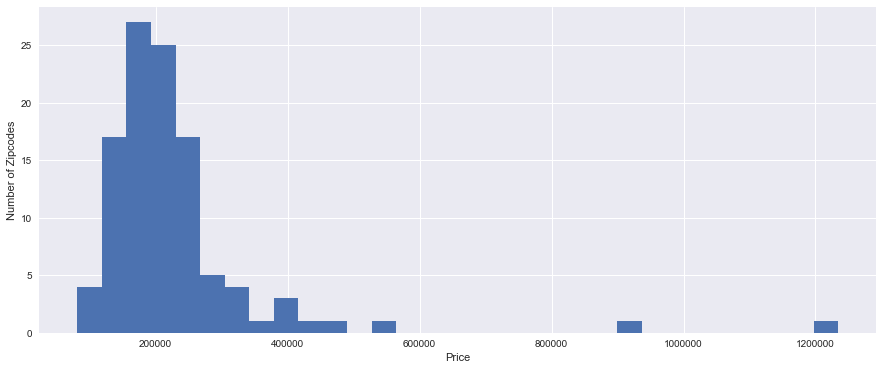

In [22]:
plt.figure(figsize=(15,6))
plt.hist(Idaho['Last12MonthAvg'], bins='auto');
plt.ylabel('Number of Zipcodes');
plt.xlabel('Price');

## Calculate ROI (1yr, 5yr, 10yr) and CV

In [23]:
#Calculate ROI for 1 year, 5 year, 10 year
Idaho['1yr_ROI'] = (Idaho['2018-04'] / Idaho['2017-04']) - 1
Idaho['5yr_ROI'] = (Idaho['2018-04'] / Idaho['2013-04']) - 1
Idaho['10yr_ROI'] = (Idaho['2018-04'] / Idaho['2008-04']) - 1

In [24]:
#Calculate CV
Idaho['std'] = Idaho.loc[:,'2006-01':'2018-04'].std(axis=1)
Idaho['mean'] = Idaho.loc[:,'2006-01':'2018-04'].mean(axis=1)
Idaho['CV'] = Idaho['std'] / Idaho['mean']

In [25]:
Idaho

,RegionName,City,State,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Last12MonthAvg,1yr_ROI,5yr_ROI,10yr_ROI,std,mean,CV
448,83301,Twin Falls,ID,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,126100.0,126700.0,128600.0,132900.0,137400.0,140400.0,142500.0,143700.0,144600.0,145300.0,145800.0,146400.0,147200.0,148200.0,148800,148600,148200,147800,147200,146500,145300,144800,146100,148100,149400,150400,151100,151100,151300,151800,152200,153000,154400,155700,156600,157400,158100,158800,159500,159500,158900,159000,160100,161300,162400,163500,164300,164400,164200,164100,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800,1.704333e+05,0.093674,0.437250,0.207522,15843.932315,1.416122e+05,0.111883
596,83709,Boise,ID,199200.0,203300.0,207200.0,211500.0,215900.0,220000.0,223300.0,225300.0,225800.0,225000.0,223700.0,222500.0,221700.0,220600.0,219500.0,218800.0,218400.0,217900.0,217600.0,217500.0,217400.0,217400.0,217300.0,217300.0,217600.0,217600.0,217100.0,216500.0,215600.0,213800.0,211500.0,208800.0,206200.0,203700.0,201300.0,199100.0,197400.0,195500.0,193300.0,191000.0,188700.0,186100.0,183900.0,182200.0,180700.0,179300.0,178100.0,176800.0,173900.0,173200.0,173800.0,172700.0,170600.0,170200.0,169200.0,167700.0,165900.0,164300.0,163200.0,162300.0,161700.0,159800.0,157300.0,155400.0,153500.0,151300.0,150100.0,149300.0,148600.0,148500.0,148200.0,147000.0,146100.0,146400.0,147000.0,147800.0,148900.0,149700.0,150100.0,150600.0,151600.0,152900.0,154300.0,156100.0,158200.0,159400.0,160200.0,161900.0,164700.0,168200.0,171800.0,174700.0,176900.0,178400.0,180400.0,183100.0,185000.0,186000.0,187300.0,188600.0,189300.0,189500.0,189300,188600,187900,187600,187700,188700,190600,192200,193100,194200,196000,198000,199500,200300,200700,201700,203300,204800,206200,207900,209300,210800,212000,213300,214300,214900,216200,218100,219900,221400,223400,225600,228500,231900,235200,237000,242200,251800,261200,263500,261100,257000,255200,255100,256200,256600,2.526750e+05,0.106511,0.584929,0.185219,29942.939507,1.947209e+05,0.153774
1178,83686,Nampa,ID,147100.0,148000.0,149400.0,151500.0,153800.0,156

In [26]:
print('Choosing to use 5yr ROI for historic ROI metric.')
print('The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.')
print('Was thinking of using ')

Choosing to use 5yr ROI for historic ROI metric.
The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.
Was thinking of using 


## Narrowing zipcodes down to historic best 25 candidates

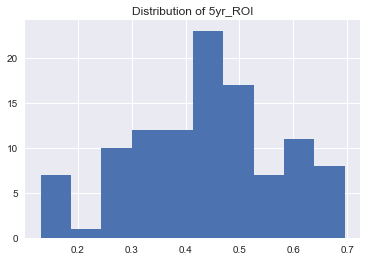

In [27]:
#Looking at distribution of 5yr_ROI
Idaho['5yr_ROI'].hist()
plt.title('Distribution of 5yr_ROI');

In [28]:
#Taking the top 25 zipcodes that have the best 5yr_ROI
Idaho_25 = Idaho.sort_values(by=['5yr_ROI'], ascending=False)[0:25]

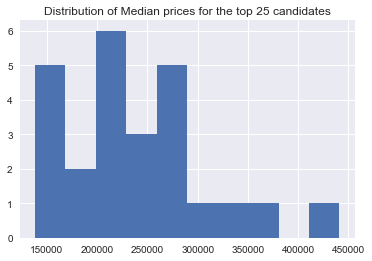

In [29]:
#Looking at the median price distribution of the top 25
Idaho_25['2018-04'].hist()
plt.title('Distribution of Median prices for the top 25 candidates');

## Turning the top 25 zip codes into long format

In [30]:
#This will take in the data(series) and turn it into a df(long format)
def LongFormat(data):
    
    #Turns series into df
    df = pd.DataFrame(data)
    
    #Drops the unwanted identity entries and calculations
    df = df.drop(labels=['RegionName','City','State','Last12MonthAvg',
                                 '1yr_ROI', '5yr_ROI', '10yr_ROI', 'std', 'mean', 'CV'],axis=0)
    
    #Turns the index into date time
    df.index = pd.to_datetime(df.index)
    df = df.asfreq('MS')
    
    #Labels the prices as value
    df.columns = ['value']
    
    return df

In [31]:
#This pulls each zipcode entry from the dataframe and appends the data to a list
Idaho_25_list = []
for i in range(len(Idaho_25)):
    Idaho_25_list.append(Idaho_25.iloc[i][:])

#Creating a dictionary with the zipcode as the key and the long format dataframe as the value
Idaho_25_dict = {}
for x in Idaho_25_list:
    Idaho_25_dict[str(x[0])] = LongFormat(x)

In [32]:
Idaho_25_dict.keys()

dict_keys(['83703', '83814', '83676', '83605', '83702', '83705', '83651', '83350', '83801', '83845', '83347', '83607', '83336', '83706', '83655', '83835', '83687', '83714', '83709', '83704', '83815', '83686', '83660', '83276', '83858'])

In [33]:
Idaho_25_dict['83703'].head()

,value
2006-01-01,182900
2006-02-01,186600
2006-03-01,190000
2006-04-01,193800
2006-05-01,197900


## Looking at the price plots (try zooming in and out)

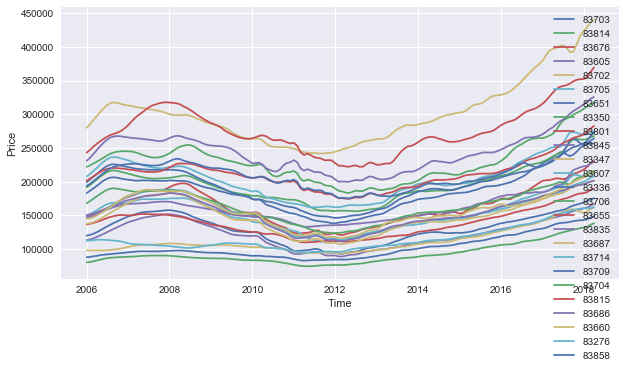

In [34]:
fig, ax = plt.subplots(figsize=(10,5))

for k,v in Idaho_25_dict.items():
        ax.plot(v, label=k)
        ax.set_ylabel('Price')
        ax.set_xlabel('Time')
        ax.legend()
        

## Seasonal Decompose

In [35]:
## Checking to see if there is any sort of seasonality to the zipcodes

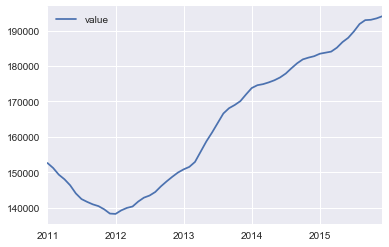

In [36]:
Idaho_25_dict['83703'][60:120].plot()

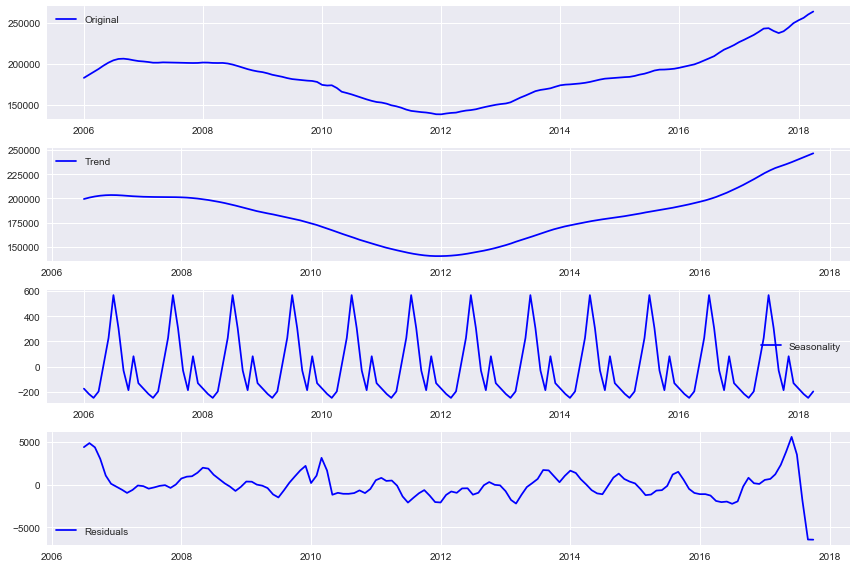

In [37]:
# Taking the decomposition of one zip code
decomposition = seasonal_decompose(Idaho_25_dict['83703'])

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Idaho_25_dict['83703'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [38]:
# Look more into the seasonal plot and see how long a "season" is. Most likely 12 months.

## Maps (Uncomment to run)

In [39]:
#with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/id_idaho_zip_codes_geo.min.json') as response:
#    Idaho_Map = json.load(response)

#Idaho_Map["features"][0]

In [40]:
#Don't run this will make the map but it will be too large of a size, deal with this later.

#fig = px.choropleth(Idaho, geojson=Idaho_Map, color="5yr_ROI",
#                    locations="RegionName", featureidkey="properties.ZCTA5CE10",
#                    projection="mercator", hover_data=['City']
#                   )
#fig.update_geos(fitbounds="locations", visible=True)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

# Modeling

## First going to make one model to see if we can get it to work

### Finding out what parameters to use

Using pmd arima to gather the parameters that are best for modeling

In [41]:
# Train size is 10 years, test size is 28 months (2 years and 4 months)
train, test = train_test_split(Idaho_25_dict['83703'], train_size=120)

In [42]:
print(train.index[0])
print(train.index[-1])

2006-01-01 00:00:00
2015-12-01 00:00:00


In [43]:
# Basically Gridsearch
auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12,
                           max_order=None,trace=True)

display(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1905.296, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1909.042, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1909.041, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1907.291, Time=0.14 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1909.519, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1910.586, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1907.080, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1907.076, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1908.770, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1907.158, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.664 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -951.648
Date:                Sun, 11 Apr 2021   AIC                           1905.296
Time:                        17:00:01   BIC                           1908.067
Sample:                             0   HQIC                          1906.421
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.921e+05   3.84e+04     15.417      0.000    5.17e+05    6.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               180.10
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.18
Prob(H) (two-sided):                  0.68   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

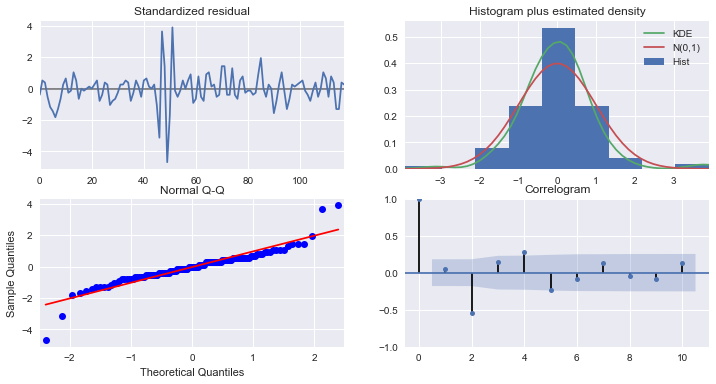

In [44]:
auto_model.plot_diagnostics(figsize=(12,6));

In [45]:
auto_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 2, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

### Using best params to make an initial model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -944.006
Date:                Sun, 11 Apr 2021   AIC                           1890.011
Time:                        17:00:03   BIC                           1892.773
Sample:                    01-01-2006   HQIC                          1891.133
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.962e+05    3.9e+04     15.305      0.000     5.2e+05    6.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               175.40
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.19
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

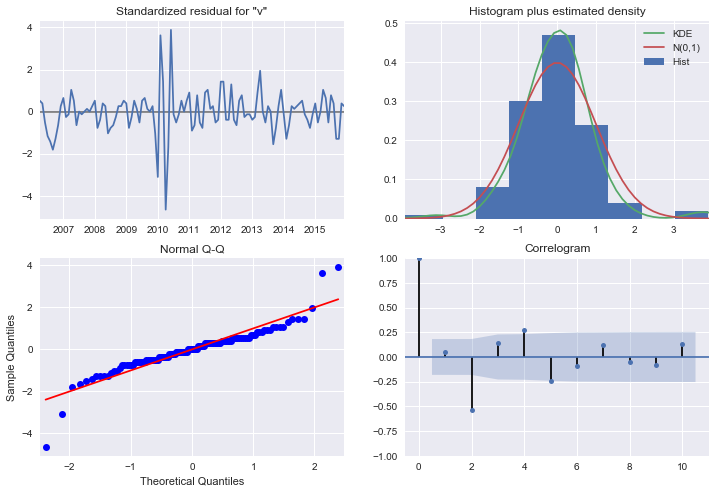

In [46]:
# Using the best params to train the model
Test_model = SARIMAX(train['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
output = Test_model.fit()
display(output.summary());
output.plot_diagnostics(figsize=(12,8));

In [47]:
# Taking the initial model and checking the predictions it makes with the trained data.
# Non dynamic
predictions = output.get_prediction(start='2014-01-01',end='2015-12-01',dynamic=False)
predictions_conf = predictions.conf_int()

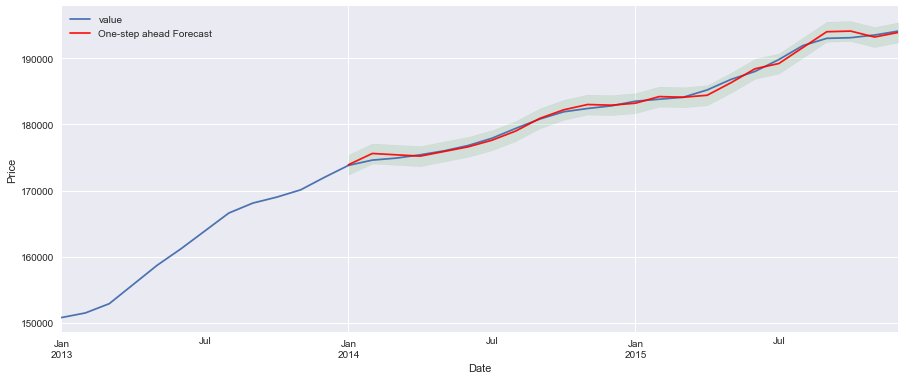

In [48]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15,6

# Plot observed values
ax = train['2013':].plot()

# Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predictions_conf.index,
                predictions_conf.iloc[:, 0],
                predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [49]:
y_hat = predictions.predicted_mean
real_values = train['2014-01-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 247916.67


In [50]:
# Taking the initial model and checking the predictions it makes with the trained data.
# dynamic
predictions_dyn = output.get_prediction(start='2014-01-01',end='2015-12-01',
                                    dynamic=True, full_results=True)
predictions_dyn_conf = predictions_dyn.conf_int()

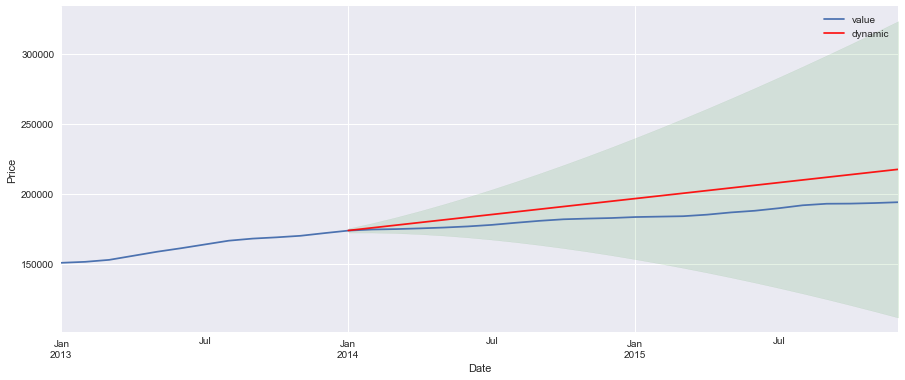

In [51]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15,6

# Plot observed values
ax = train['2013':'2015-12-01'].plot()

# Plot predicted values
predictions_dyn.predicted_mean.plot(ax=ax, label='dynamic', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predictions_dyn_conf.index,
                predictions_dyn_conf.iloc[:, 0],
                predictions_dyn_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [52]:
y_hat = predictions_dyn.predicted_mean
real_values = train['2014-01-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 196297916.67


The dynamic forecasting does much worse than the one-step forecasting. Dynamic is more true to how the actual model will perform.

In [53]:
# Looking at the forecast for the "test" data. To see if it is able to forecast well.
forecast = output.get_forecast(steps = 28)
forecast_conf = forecast.conf_int()

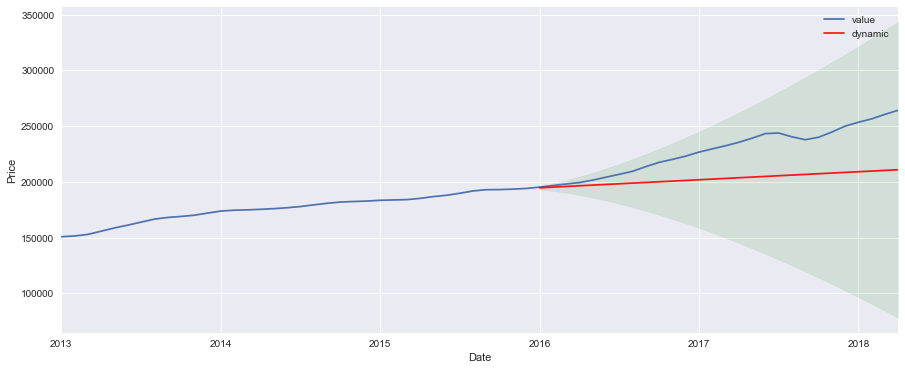

In [54]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15,6

# Plot observed values
ax = Idaho_25_dict['83703']['2013':].plot()

# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='dynamic', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [55]:
y_hat = forecast.predicted_mean
real_values = Idaho_25_dict['83703']['2016-01-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 886545357.14


### Making the final model to predict future prices

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1204.754
Date:                Sun, 11 Apr 2021   AIC                           2411.508
Time:                        17:00:05   BIC                           2414.485
Sample:                    01-01-2006   HQIC                          2412.717
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.641e+05    5.3e+04     18.185      0.000     8.6e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.58   Jarque-Bera (JB):               305.86
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

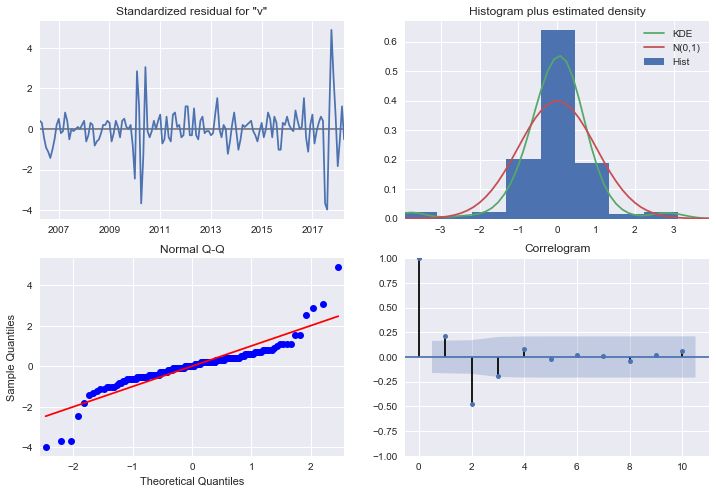

In [56]:
# Making a model for the data we have (train + test) and seeing future predictions
Final_model = SARIMAX(Idaho_25_dict['83703']['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
Final_output = Final_model.fit()
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(12,8));

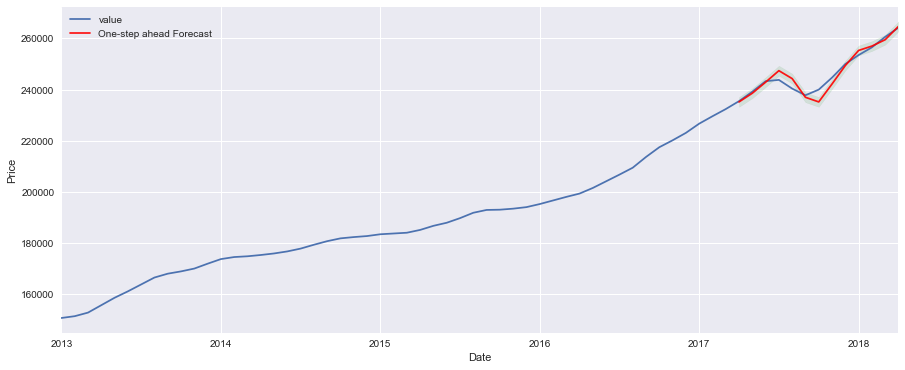

In [57]:
# Checking one step prediction on the last year of data
Final_predictions = Final_output.get_prediction(start='2017-04-01',end='2018-04-01',dynamic=False)
Final_predictions_conf = Final_predictions.conf_int()

# Plot observed values
ax = Idaho_25_dict['83703']['value']['2013':].plot()

# Plot predicted values
Final_predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(Final_predictions_conf.index,
                Final_predictions_conf.iloc[:, 0],
                Final_predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [58]:
y_hat = Final_predictions.predicted_mean
real_values = Idaho_25_dict['83703']['2017-04-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4924615.38


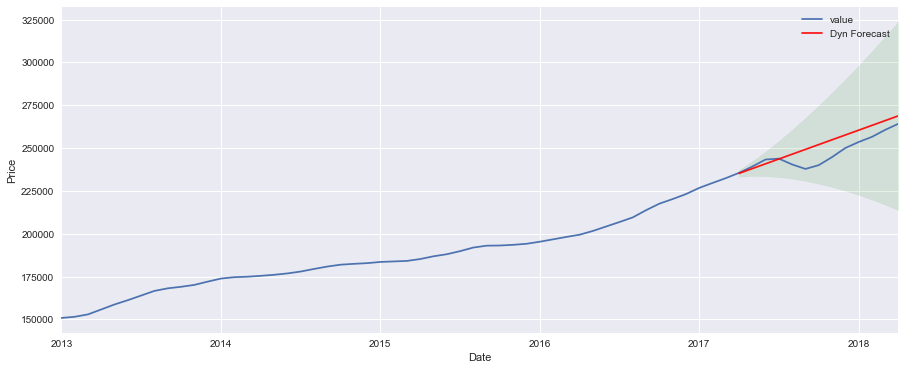

In [59]:
# Checking one step prediction on the last year of data
Final_dyn_predictions = Final_output.get_prediction(start='2017-04-01',end='2018-04-01',dynamic=True)
Final_dyn_predictions_conf = Final_dyn_predictions.conf_int()

# Plot observed values
ax = Idaho_25_dict['83703']['value']['2013':].plot()

# Plot predicted values
Final_dyn_predictions.predicted_mean.plot(ax=ax, label='Dyn Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(Final_dyn_predictions_conf.index,
                Final_dyn_predictions_conf.iloc[:, 0],
                Final_dyn_predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [60]:
y_hat = Final_dyn_predictions.predicted_mean
real_values = Idaho_25_dict['83703']['2017-04-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 47720769.23


In [61]:
# Getting the next year's price predictions and the confidence interval
future_year = Final_output.get_forecast(steps=12)
future_year_conf = future_year.conf_int()

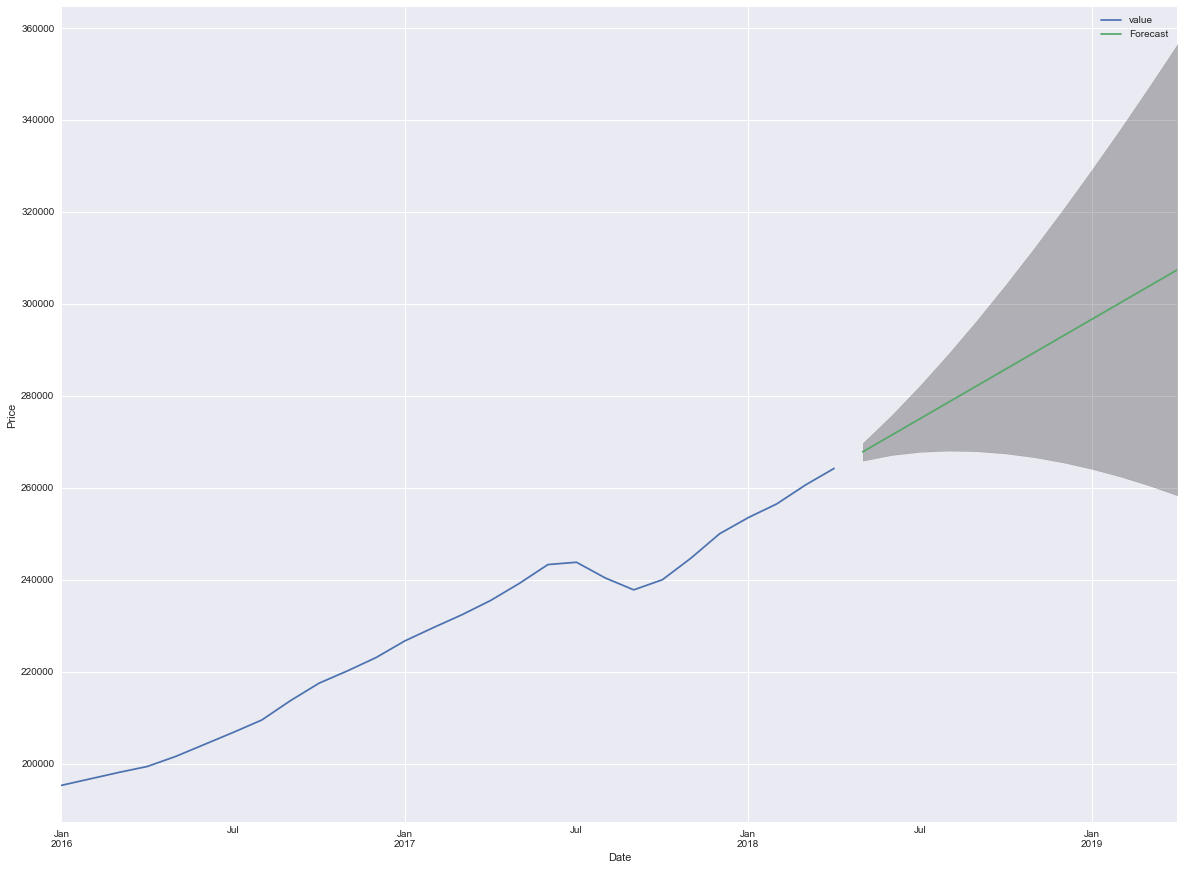

In [62]:
# Plotting the next predicted years prices
ax=Idaho_25_dict['83703']['2016':].plot(label='Observed', figsize=(20,15))

future_year.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(future_year_conf.index,
                future_year_conf.iloc[:,0],
                future_year_conf.iloc[:,1],
                color='k',
                alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [63]:
future_year.predicted_mean[-1]

307400.0

## Making a function to model all 25 zipcodes

Make sure to have a table that will store all aspects of the models.

In [64]:
# This function will automatically train/test split the data
# Then grid search for the best parameters
# Then create a model on the training data and check it against the test data
# Finally it will create a final model and give us a one year prediction

def autobot(data, beg='2013', train_check_start='2014-01-01',
            train_check_end='2015-12-01', final_check_start='2016-01-01',
            final_check_end='2018-04-01', train_size=120, future=12):

    
    # Train size is 10 years, test size is 28 months (2 years and 4 months)
    train, test = train_test_split(data, train_size=train_size)
    
    # Using pm auto_arima to find the best parameters
    auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12, trace=True)
    print('Auto_model summary')
    display(auto_model.summary())
    
    # Getting the order and seasonal_order
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    
    # Making the Initial SARIMAX model with the best parameters
    Train_model = SARIMAX(train['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    train_output = Train_model.fit()
    print('Train_model summary')
    display(train_output.summary());
    
    # Getting One Step prediction to check initial model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check initial model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the initial model does compared to the test
    train_forecast = train_output.get_forecast(steps = 28)
    train_forecast_conf = train_forecast.conf_int()
    
    
    # Calculating MSE for all predictions/forecast for initial model
    train_mse = mse_calc(data=train, prediction=train_prediction, 
                         start=train_check_start)
    train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
                             start=train_check_start)
    train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
                                  start=final_check_start)
    
    
    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the initial model does compared to the test
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()
    
    
    # Calculating MSE for all predictions for initial model
    final_mse = mse_calc(data=data, prediction=final_prediction, 
                         start=final_check_start)
    final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
                             start=final_check_start)

    
    return [order, seasonal_order, train_mse, train_dyn_mse, train_forecast_mse, final_mse,
            final_dyn_mse, data.loc[final_check_end]['value'],
            final_forecast.predicted_mean[-1]]

In [65]:
# This function will plot the timeseries and the predicted values from the model

def PlotPredictions(obs_data, pred_data, pred_data_conf, beg='2013'):
    # Plot observed values
    ax = obs_data[beg:].plot(label='Observed')

    # Plot predicted values
    pred_data.predicted_mean.plot(ax=ax)

    # Plot the range for confidence intervals
    ax.fill_between(pred_data_conf.index,
                pred_data_conf.iloc[:, 0],
                pred_data_conf.iloc[:, 1], color='g', alpha=0.1)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [66]:
# This function will calculate the mse

def mse_calc(data, prediction, start):
    y_hat = prediction.predicted_mean
    real_values = data[start:]['value']
    mse = ((real_values-y_hat)**2).mean()
    return mse

In [67]:
# Looping through the zipcodes in the dictionary and finding the best model and finding
# the one year prediction

i = 0
for k,v in Idaho_25_dict.items():
    if i==0:
        results = autobot(v)
        results.append(k)
        results_df=pd.DataFrame(pd.Series(results))
        results_df=results_df.T
        results_df.columns=['order','seasonal_order','train_mse','train_dyn_mse',
                        'train_forecast_mse','final_mse','final_dyn_mse',
                        'last_known_price','1_year_forecast','zip']
        i+=1
        
    elif i>0:
        results = autobot(v)
        results.append(k)
        results_df = results_df.append(pd.Series(results, index=results_df.columns), ignore_index=True)
        i+=1
        
results_df.set_index('zip', inplace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1905.296, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1909.042, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1909.041, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1907.291, Time=0.18 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1909.519, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1910.586, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1907.080, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1907.076, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1908.770, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1907.158, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.621 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -951.648
Date:                Sun, 11 Apr 2021   AIC                           1905.296
Time:                        17:00:08   BIC                           1908.067
Sample:                             0   HQIC                          1906.421
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.921e+05   3.84e+04     15.417      0.000    5.17e+05    6.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               180.10
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.18
Prob(H) (two-sided):                  0.68   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -944.006
Date:                Sun, 11 Apr 2021   AIC                           1890.011
Time:                        17:00:08   BIC                           1892.773
Sample:                    01-01-2006   HQIC                          1891.133
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.962e+05    3.9e+04     15.305      0.000     5.2e+05    6.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               175.40
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.19
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1204.754
Date:                Sun, 11 Apr 2021   AIC                           2411.508
Time:                        17:00:08   BIC                           2414.485
Sample:                    01-01-2006   HQIC                          2412.717
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.641e+05    5.3e+04     18.185      0.000     8.6e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.58   Jarque-Bera (JB):               305.86
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2169.452, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2211.877, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2169.013, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2167.508, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2171.419, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2171.420, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2173.441, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2209.946, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2167.040, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2169.013, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2171.699, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2166.259, Time=0.14 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2168.235, Time=0.28 sec
 ARIMA(0,1,2)(0,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1075.703
Date:                Sun, 11 Apr 2021   AIC                           2161.407
Time:                        17:00:14   BIC                           2175.302
Sample:                             0   HQIC                          2167.049
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -92.9487     62.805     -1.480      0.139    -216.045      30.148
ar.L1          0.8661      0.094      9.242      0.000       0.682       1.050
ma.L1         -0.8400      0.095     -8.831      0.000      -1.026      -0.654
ma.L2          0.0040      0.015      0.273      0.785      -0.025       0.033
sigma2      4.148e+06      0.001   3.25e+09      0.000    4.15e+06    4.15e+06
===================================================================================
Ljung-Box (L1) (Q):                  57.37   Jarque-Bera (JB):                14.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.63
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.1e+24. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -975.199
Date:                Sun, 11 Apr 2021   AIC                           1958.398
Time:                        17:00:14   BIC                           1969.412
Sample:                    01-01-2006   HQIC                          1962.869
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0158      0.033      0.486      0.627      -0.048       0.080
ma.L1          1.6744      0.084     19.941      0.000       1.510       1.839
ma.L2          0.9639      0.089     10.823      0.000       0.789       1.139
sigma2      1.491e+06   1.21e+05     12.361      0.000    1.25e+06    1.73e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               885.13
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -2.35
Prob(H) (two-sided):                  0.65   Kurtosis:                        15.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1213.257
Date:                Sun, 11 Apr 2021   AIC                           2434.514
Time:                        17:00:15   BIC                           2446.393
Sample:                    01-01-2006   HQIC                          2439.341
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0218      0.033      0.657      0.511      -0.043       0.087
ma.L1          1.6676      0.053     31.557      0.000       1.564       1.771
ma.L2          0.9638      0.057     16.823      0.000       0.852       1.076
sigma2      1.523e+06    1.1e+05     13.875      0.000    1.31e+06    1.74e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               814.13
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -1.84
Prob(H) (two-sided):                  0.02   Kurtosis:                        14.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2149.322, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2147.016, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2147.223, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2148.426, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2146.983, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2147.087, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2304.028, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2144.992, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2145.050, Time=0.26 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2145.115, Time=0.22 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2146.798, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=2142.753, Time=0.14 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2142.842, Time=0.31 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=2142.902, Time=0.28 sec
 ARIMA(3,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1062.536
Date:                Sun, 11 Apr 2021   AIC                           2137.073
Time:                        17:00:24   BIC                           2153.748
Sample:                             0   HQIC                          2143.844
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0286      0.010      2.771      0.006       0.008       0.049
ar.L2          0.0272      0.016      1.754      0.079      -0.003       0.058
ar.L3          0.0300      0.020      1.508      0.131      -0.009       0.069
ar.L4          0.0307      0.019      1.599      0.110      -0.007       0.068
ar.L5          0.0294      0.020      1.441      0.150      -0.011       0.069
sigma2       3.21e+06   1.44e-10   2.22e+16      0.000    3.21e+06    3.21e+06
===================================================================================
Ljung-Box (L1) (Q):                  80.43   Jarque-Bera (JB):                 8.05
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.48   Skew:                            -0.52
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -908.948
Date:                Sun, 11 Apr 2021   AIC                           1829.895
Time:                        17:00:24   BIC                           1846.312
Sample:                    01-01-2006   HQIC                          1836.558
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6679      0.097     17.271      0.000       1.479       1.857
ar.L2         -1.5409      0.175     -8.785      0.000      -1.885      -1.197
ar.L3          1.0931      0.216      5.049      0.000       0.669       1.517
ar.L4         -0.3799      0.180     -2.108      0.035      -0.733      -0.027
ar.L5          0.0648      0.093      0.700      0.484      -0.117       0.246
sigma2      4.932e+05    5.7e+04      8.650      0.000    3.81e+05    6.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.64
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1142.372
Date:                Sun, 11 Apr 2021   AIC                           2296.744
Time:                        17:00:24   BIC                           2314.479
Sample:                    01-01-2006   HQIC                          2303.950
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6349      0.095     17.124      0.000       1.448       1.822
ar.L2         -1.5384      0.169     -9.120      0.000      -1.869      -1.208
ar.L3          1.1090      0.194      5.717      0.000       0.729       1.489
ar.L4         -0.3852      0.165     -2.339      0.019      -0.708      -0.062
ar.L5          0.0951      0.089      1.063      0.288      -0.080       0.270
sigma2      5.691e+05   5.95e+04      9.570      0.000    4.53e+05    6.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.01
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.96   Skew:                            -0.27
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2078.679, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2070.789, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2075.466, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2077.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2073.282, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2072.695, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2070.762, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2072.755, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2074.239, Time=0.93 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2076.394, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2065.374, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2067.943, Time=0.10 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,0)(0,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood               -1000.929
Date:                             Sun, 11 Apr 2021   AIC                           2021.857
Time:                                     17:01:00   BIC                           2049.648
Sample:                                          0   HQIC                          2033.142
                                             - 120                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -26.9683     23.888     -1.129      0.259     -73.789      19.852
ar.L1          0.8531      0.077     11.021      0.000       0.701       1.005
ar.L2          0.0033      0.023      0.146      0.884      -0.042       0.048
ar.L3          0.0091      0.034      0.266      0.790      -0.058       0.077
ar.L4          0.0091      0.040      0.227      0.820      -0.069       0.087
ar.L5          0.0163      0.031      0.523      0.601      -0.045       0.078
ma.L1         -0.8216      0.076    -10.800      0.000      -0.971      -0.672
ar.S.L12       0.0127      0.109      0.117      0.907      -0.201       0.227
ar.S.L24      -0.0017      0.098     -0.017      0.986      -0.194       0.191
sigma2      1.212e+06      0.001   1.02e+09      0.000    1.21e+06    1.21e+06
===================================================================================
Ljung-Box (L1) (Q):                  81.14   Jarque-Bera (JB):                12.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.78
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+25. Standard errors may be unstable.
"""

Train_model summary


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood                -678.311
Date:                             Sun, 11 Apr 2021   AIC                           1374.621
Time:                                     17:01:01   BIC                           1397.120
Sample:                                 01-01-2006   HQIC                          1383.694
                                      - 12-01-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8536      0.235      3.628      0.000       0.392       1.315
ar.L2         -0.0908      0.284     -0.320      0.749      -0.648       0.466
ar.L3         -0.2853      0.239     -1.196      0.232      -0.753       0.182
ar.L4          0.7344      0.201      3.655      0.000       0.341       1.128
ar.L5         -0.3380      0.139     -2.439      0.015      -0.609      -0.066
ma.L1          0.7918      0.215      3.675      0.000       0.370       1.214
ar.S.L12      -0.1928      0.129     -1.498      0.134      -0.445       0.059
ar.S.L24       0.0222      0.061      0.367      0.714      -0.097       0.141
sigma2      2.051e+05   1.74e+04     11.773      0.000    1.71e+05    2.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                93.50
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  148
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood                -884.891
Date:                             Sun, 11 Apr 2021   AIC                           1787.782
Time:                                     17:01:02   BIC                           1812.718
Sample:                                 01-01-2006   HQIC                          1797.907
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5463     12.707      0.122      0.903     -23.360      26.452
ar.L2         -1.2447     19.836     -0.063      0.950     -40.122      37.632
ar.L3          0.8195     16.127      0.051      0.959     -30.788      32.427
ar.L4         -0.1569     10.694     -0.015      0.988     -21.117      20.803
ar.L5         -0.0064      2.227     -0.003      0.998      -4.372       4.359
ma.L1          0.0137     12.719      0.001      0.999     -24.916      24.943
ar.S.L12      -0.1478      0.099     -1.485      0.137      -0.343       0.047
ar.S.L24      -0.1776      0.106     -1.672      0.094      -0.386       0.031
sigma2      1.775e+05   1.29e+04     13.724      0.000    1.52e+05    2.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               126.49
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1929.428, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1937.473, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1932.998, Time=0.20 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1931.624, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1932.682, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1934.551, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1935.473, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1931.000, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1948.041, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1931.100, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.625 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -963.714
Date:                Sun, 11 Apr 2021   AIC                           1929.428
Time:                        17:01:02   BIC                           1932.199
Sample:                             0   HQIC                          1930.553
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.265e+05   8.32e+04      8.733      0.000    5.63e+05     8.9e+05
===================================================================================
Ljung-Box (L1) (Q):                  28.57   Jarque-Bera (JB):                 2.48
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               2.62   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -956.038
Date:                Sun, 11 Apr 2021   AIC                           1914.076
Time:                        17:01:02   BIC                           1916.839
Sample:                    01-01-2006   HQIC                          1915.198
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.325e+05   8.47e+04      8.647      0.000    5.66e+05    8.99e+05
===================================================================================
Ljung-Box (L1) (Q):                  28.37   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               2.50   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1275.088
Date:                Sun, 11 Apr 2021   AIC                           2552.175
Time:                        17:01:03   BIC                           2555.152
Sample:                    01-01-2006   HQIC                          2553.385
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.509e+06   9.15e+04     27.416      0.000    2.33e+06    2.69e+06
===================================================================================
Ljung-Box (L1) (Q):                  20.34   Jarque-Bera (JB):              2122.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.09   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1849.886, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1853.408, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1853.385, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1851.828, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1852.853, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1854.870, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1851.466, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1851.441, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1852.829, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1851.863, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.526 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -923.943
Date:                Sun, 11 Apr 2021   AIC                           1849.886
Time:                        17:01:03   BIC                           1852.657
Sample:                             0   HQIC                          1851.011
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.702e+05   3.67e+04     10.079      0.000    2.98e+05    4.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.79   Jarque-Bera (JB):                10.82
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.16
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -916.557
Date:                Sun, 11 Apr 2021   AIC                           1835.115
Time:                        17:01:03   BIC                           1837.877
Sample:                    01-01-2006   HQIC                          1836.236
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.729e+05   3.73e+04      9.996      0.000       3e+05    4.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.85   Jarque-Bera (JB):                10.24
Prob(Q):                              0.09   Prob(JB):                         0.01
Heteroskedasticity (H):               0.98   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1167.955
Date:                Sun, 11 Apr 2021   AIC                           2337.911
Time:                        17:01:03   BIC                           2340.888
Sample:                    01-01-2006   HQIC                          2339.120
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.804e+05   3.59e+04     16.149      0.000     5.1e+05    6.51e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.19   Jarque-Bera (JB):               176.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2093.403, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2087.350, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2092.354, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2092.363, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2088.988, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2089.301, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2087.340, Time=0.25 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2089.339, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2091.843, Time=0.10 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2082.202, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2083.891, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2084.201, Time=0.56 sec
 ARIMA(2,1,0)(0,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1017.419
Date:                            Sun, 11 Apr 2021   AIC                           2052.837
Time:                                    17:01:31   BIC                           2077.849
Sample:                                         0   HQIC                          2062.994
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -162.7335     55.749     -2.919      0.004    -271.999     -53.468
ar.L1          0.6504      0.099      6.591      0.000       0.457       0.844
ar.L2          0.0152      0.017      0.881      0.378      -0.019       0.049
ar.L3          0.0197      0.025      0.794      0.427      -0.029       0.068
ar.L4          0.0242      0.028      0.868      0.385      -0.031       0.079
ar.L5          0.0403      0.018      2.183      0.029       0.004       0.076
ma.L1         -0.6161      0.099     -6.220      0.000      -0.810      -0.422
ma.S.L12       0.0274      0.065      0.419      0.675      -0.101       0.156
sigma2      1.137e+06      0.001   1.01e+09      0.000    1.14e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                  79.73   Jarque-Bera (JB):                 9.27
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.71   Skew:                            -0.68
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.83e+25. Standard errors may be unstable.
"""

Train_model summary


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -790.612
Date:                            Sun, 11 Apr 2021   AIC                           1597.224
Time:                                    17:01:31   BIC                           1618.456
Sample:                                01-01-2006   HQIC                          1605.828
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2316      0.321      3.836      0.000       0.602       1.861
ar.L2         -0.7294      0.537     -1.359      0.174      -1.782       0.323
ar.L3          0.3701      0.477      0.776      0.438      -0.565       1.305
ar.L4          0.1481      0.346      0.427      0.669      -0.531       0.827
ar.L5         -0.1237      0.135     -0.915      0.360      -0.389       0.141
ma.L1          2.0820      1.382      1.506      0.132      -0.627       4.791
ma.S.L12      -0.2029      0.097     -2.083      0.037      -0.394      -0.012
sigma2      4.616e+04   6.15e+04      0.750      0.453   -7.44e+04    1.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               165.00
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -1.30
Prob(H) (two-sided):                  0.39   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  148
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -997.021
Date:                            Sun, 11 Apr 2021   AIC                           2010.042
Time:                                    17:01:32   BIC                           2033.165
Sample:                                01-01-2006   HQIC                          2019.439
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1614      0.386      3.006      0.003       0.404       1.919
ar.L2         -0.5879      0.627     -0.937      0.349      -1.817       0.641
ar.L3          0.2687      0.531      0.506      0.613      -0.773       1.310
ar.L4          0.2161      0.374      0.577      0.564      -0.518       0.950
ar.L5         -0.1472      0.134     -1.099      0.272      -0.410       0.115
ma.L1          1.9942      1.522      1.311      0.190      -0.988       4.976
ma.S.L12      -0.1619      0.095     -1.708      0.088      -0.348       0.024
sigma2      4.732e+04   7.24e+04      0.654      0.513   -9.46e+04    1.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               182.46
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -1.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1595.480, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1599.198, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1599.145, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1597.143, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1597.165, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1597.196, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1597.472, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1597.468, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1598.362, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1597.472, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.677 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -796.740
Date:                Sun, 11 Apr 2021   AIC                           1595.480
Time:                        17:01:33   BIC                           1598.251
Sample:                             0   HQIC                          1596.605
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.288e+04   4763.819      9.000      0.000    3.35e+04    5.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.58   Jarque-Bera (JB):                 6.07
Prob(Q):                              0.06   Prob(JB):                         0.05
Heteroskedasticity (H):               2.28   Skew:                             0.42
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -789.436
Date:                Sun, 11 Apr 2021   AIC                           1580.872
Time:                        17:01:33   BIC                           1583.634
Sample:                    01-01-2006   HQIC                          1581.994
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.248e+04   4685.143      9.067      0.000    3.33e+04    5.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.73   Jarque-Bera (JB):                 7.02
Prob(Q):                              0.10   Prob(JB):                         0.03
Heteroskedasticity (H):               2.41   Skew:                             0.44
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1011.585
Date:                Sun, 11 Apr 2021   AIC                           2025.170
Time:                        17:01:33   BIC                           2028.147
Sample:                    01-01-2006   HQIC                          2026.379
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.717e+04   5232.774     12.836      0.000    5.69e+04    7.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):                47.45
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               5.77   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2227.074, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2304.651, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2234.753, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2226.551, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2226.132, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2227.830, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2227.988, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2226.087, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2227.879, Time=0.13 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2229.724, Time=0.39 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2304.537, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2229.383, Time=0.40 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=2226.234, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,1)[12] intercept
Total fit time: 1.570 seconds
Auto_mod

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1110.043
Date:                              Sun, 11 Apr 2021   AIC                           2226.087
Time:                                      17:01:34   BIC                           2234.424
Sample:                                           0   HQIC                          2229.472
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    307.5630    264.458      1.163      0.245    -210.765     825.891
ma.S.L12       0.0221      0.063      0.351      0.726      -0.102       0.146
sigma2      7.598e+06   9.79e+05      7.761      0.000    5.68e+06    9.52e+06
===================================================================================
Ljung-Box (L1) (Q):                  72.52   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.00   Prob(JB):                         0.73
Heteroskedasticity (H):               0.61   Skew:                            -0.16
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -984.944
Date:                              Sun, 11 Apr 2021   AIC                           1973.888
Time:                                      17:01:35   BIC                           1979.215
Sample:                                  01-01-2006   HQIC                          1976.047
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1209      0.105      1.155      0.248      -0.084       0.326
sigma2      6.915e+06   8.48e+05      8.158      0.000    5.25e+06    8.58e+06
===================================================================================
Ljung-Box (L1) (Q):                  59.94   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               0.98   Skew:                            -0.13
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  148
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1250.622
Date:                              Sun, 11 Apr 2021   AIC                           2505.244
Time:                                      17:01:35   BIC                           2511.039
Sample:                                  01-01-2006   HQIC                          2507.599
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.3625      0.086      4.210      0.000       0.194       0.531
sigma2       8.15e+06    9.9e+05      8.229      0.000    6.21e+06    1.01e+07
===================================================================================
Ljung-Box (L1) (Q):                  78.39   Jarque-Bera (JB):                 7.86
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.38   Skew:                            -0.43
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1732.645, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1736.231, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1736.070, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1734.461, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1734.263, Time=0.10 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1739.688, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1734.450, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1734.445, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1738.202, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1734.622, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.631 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -865.322
Date:                Sun, 11 Apr 2021   AIC                           1732.645
Time:                        17:01:35   BIC                           1735.415
Sample:                             0   HQIC                          1733.769
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.371e+05   1.38e+04      9.908      0.000     1.1e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.53   Jarque-Bera (JB):                14.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.41   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -858.451
Date:                Sun, 11 Apr 2021   AIC                           1718.901
Time:                        17:01:35   BIC                           1721.664
Sample:                    01-01-2006   HQIC                          1720.023
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.381e+05   1.41e+04      9.822      0.000    1.11e+05    1.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.51   Jarque-Bera (JB):                14.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.44   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1174.040
Date:                Sun, 11 Apr 2021   AIC                           2350.079
Time:                        17:01:35   BIC                           2353.056
Sample:                    01-01-2006   HQIC                          2351.289
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.312e+05   2.66e+04     23.759      0.000    5.79e+05    6.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.98   Jarque-Bera (JB):              1120.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.66   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1667.047, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1670.854, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1670.622, Time=0.14 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1668.935, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1668.938, Time=0.06 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1668.946, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1668.712, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1670.321, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1668.891, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.741 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -832.523
Date:                Sun, 11 Apr 2021   AIC                           1667.047
Time:                        17:01:36   BIC                           1669.817
Sample:                             0   HQIC                          1668.172
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.863e+04   9590.690      8.198      0.000    5.98e+04    9.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.43   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.00   Prob(JB):                         0.82
Heteroskedasticity (H):               4.66   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -825.713
Date:                Sun, 11 Apr 2021   AIC                           1653.426
Time:                        17:01:36   BIC                           1656.189
Sample:                    01-01-2006   HQIC                          1654.548
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.895e+04   9672.778      8.162      0.000       6e+04    9.79e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.44   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.00   Prob(JB):                         0.83
Heteroskedasticity (H):               4.46   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1106.724
Date:                Sun, 11 Apr 2021   AIC                           2215.448
Time:                        17:01:36   BIC                           2218.425
Sample:                    01-01-2006   HQIC                          2216.658
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.494e+05   1.12e+04     22.342      0.000    2.28e+05    2.71e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.03   Jarque-Bera (JB):               848.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.05   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2121.190, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2117.052, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2117.289, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2119.556, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2118.720, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2119.011, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2117.038, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2119.036, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2119.642, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2114.185, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2115.888, Time=0.13 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2116.185, Time=0.43 sec
 ARIMA(2,1,0)(0,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1038.128
Date:                            Sun, 11 Apr 2021   AIC                           2094.256
Time:                                    17:02:03   BIC                           2119.268
Sample:                                         0   HQIC                          2104.413
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -243.6867     64.191     -3.796      0.000    -369.498    -117.875
ar.L1          0.6060      0.084      7.196      0.000       0.441       0.771
ar.L2          0.0127      0.016      0.796      0.426      -0.019       0.044
ar.L3          0.0198      0.021      0.927      0.354      -0.022       0.062
ar.L4          0.0209      0.023      0.901      0.367      -0.025       0.066
ar.L5          0.0394      0.014      2.852      0.004       0.012       0.067
ma.L1         -0.5804      0.084     -6.883      0.000      -0.746      -0.415
ma.S.L12       0.0286      0.034      0.834      0.404      -0.039       0.096
sigma2      1.594e+06      0.001   2.14e+09      0.000    1.59e+06    1.59e+06
===================================================================================
Ljung-Box (L1) (Q):                  76.45   Jarque-Bera (JB):                20.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.96
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+25. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -810.170
Date:                            Sun, 11 Apr 2021   AIC                           1636.340
Time:                                    17:02:03   BIC                           1657.572
Sample:                                01-01-2006   HQIC                          1644.944
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7336      0.371      1.978      0.048       0.007       1.461
ar.L2          0.0646      0.569      0.114      0.910      -1.050       1.179
ar.L3         -0.3687      0.452     -0.815      0.415      -1.255       0.517
ar.L4          0.6881      0.321      2.143      0.032       0.059       1.318
ar.L5         -0.3008      0.133     -2.265      0.024      -0.561      -0.040
ma.L1          1.0761      0.415      2.594      0.009       0.263       1.889
ma.S.L12       0.0063      0.111      0.057      0.954      -0.211       0.224
sigma2      2.728e+05   2.06e+05      1.325      0.185   -1.31e+05    6.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               192.05
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -1.49
Prob(H) (two-sided):                  0.44   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  148
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1024.863
Date:                            Sun, 11 Apr 2021   AIC                           2065.726
Time:                                    17:02:04   BIC                           2088.849
Sample:                                01-01-2006   HQIC                          2075.122
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7063      0.350      2.019      0.044       0.021       1.392
ar.L2          0.0928      0.533      0.174      0.862      -0.952       1.138
ar.L3         -0.3710      0.434     -0.854      0.393      -1.222       0.480
ar.L4          0.6964      0.303      2.298      0.022       0.102       1.290
ar.L5         -0.2714      0.121     -2.243      0.025      -0.509      -0.034
ma.L1          1.0652      0.391      2.725      0.006       0.299       1.831
ma.S.L12      -0.0083      0.083     -0.100      0.920      -0.171       0.155
sigma2       2.69e+05   1.92e+05      1.405      0.160   -1.06e+05    6.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               174.73
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -1.18
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1652.734, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1655.619, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1655.479, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1653.793, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1653.742, Time=0.07 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1654.608, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1654.468, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1654.547, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1654.690, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.666 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -825.367
Date:                Sun, 11 Apr 2021   AIC                           1652.734
Time:                        17:02:04   BIC                           1655.505
Sample:                             0   HQIC                          1653.859
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.965e+04   8103.879      8.594      0.000    5.38e+04    8.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.61   Jarque-Bera (JB):                 1.29
Prob(Q):                              0.02   Prob(JB):                         0.52
Heteroskedasticity (H):               4.88   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -818.585
Date:                Sun, 11 Apr 2021   AIC                           1639.170
Time:                        17:02:05   BIC                           1641.932
Sample:                    01-01-2006   HQIC                          1640.291
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.989e+04   8163.364      8.562      0.000    5.39e+04    8.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.37   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.02   Prob(JB):                         0.53
Heteroskedasticity (H):               4.60   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1045.175
Date:                Sun, 11 Apr 2021   AIC                           2092.349
Time:                        17:02:05   BIC                           2095.326
Sample:                    01-01-2006   HQIC                          2093.559
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.067e+05   9212.378     11.586      0.000    8.87e+04    1.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.68   Jarque-Bera (JB):                22.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.84   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1842.763, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1846.387, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1846.381, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1844.733, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1844.733, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1846.941, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1844.418, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1844.412, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1846.627, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1844.645, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.706 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -920.381
Date:                Sun, 11 Apr 2021   AIC                           1842.763
Time:                        17:02:05   BIC                           1845.533
Sample:                             0   HQIC                          1843.888
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.485e+05   4.52e+04      7.705      0.000     2.6e+05    4.37e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.08   Jarque-Bera (JB):                 1.29
Prob(Q):                              0.00   Prob(JB):                         0.53
Heteroskedasticity (H):               1.58   Skew:                            -0.26
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -913.065
Date:                Sun, 11 Apr 2021   AIC                           1828.130
Time:                        17:02:05   BIC                           1830.893
Sample:                    01-01-2006   HQIC                          1829.252
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.513e+05    4.6e+04      7.630      0.000    2.61e+05    4.42e+05
===================================================================================
Ljung-Box (L1) (Q):                  22.78   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               1.58   Skew:                            -0.25
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1172.065
Date:                Sun, 11 Apr 2021   AIC                           2346.130
Time:                        17:02:05   BIC                           2349.107
Sample:                    01-01-2006   HQIC                          2347.339
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.142e+05   3.73e+04     16.484      0.000    5.41e+05    6.87e+05
===================================================================================
Ljung-Box (L1) (Q):                  28.76   Jarque-Bera (JB):               196.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.07   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1748.264, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1750.322, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1750.864, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1748.731, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1748.720, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1749.787, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1749.735, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1750.029, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1750.251, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.732 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -873.132
Date:                Sun, 11 Apr 2021   AIC                           1748.264
Time:                        17:02:06   BIC                           1751.035
Sample:                             0   HQIC                          1749.389
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.565e+05   1.89e+04      8.266      0.000    1.19e+05    1.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.34   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.01   Prob(JB):                         0.68
Heteroskedasticity (H):               1.51   Skew:                             0.11
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -866.231
Date:                Sun, 11 Apr 2021   AIC                           1734.461
Time:                        17:02:06   BIC                           1737.223
Sample:                    01-01-2006   HQIC                          1735.583
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.578e+05   1.93e+04      8.184      0.000     1.2e+05    1.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.28   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.01   Prob(JB):                         0.72
Heteroskedasticity (H):               1.47   Skew:                             0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1082.574
Date:                Sun, 11 Apr 2021   AIC                           2167.148
Time:                        17:02:07   BIC                           2170.125
Sample:                    01-01-2006   HQIC                          2168.357
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.788e+05   1.69e+04     10.552      0.000    1.46e+05    2.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.12   Jarque-Bera (JB):                 8.88
Prob(Q):                              0.02   Prob(JB):                         0.01
Heteroskedasticity (H):               1.62   Skew:                             0.30
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2199.178, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2236.144, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2194.565, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2197.467, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2192.760, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2226.822, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2228.239, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2166.885, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2199.688, Time=0.18 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2199.736, Time=0.15 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2200.835, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2234.571, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2208.495, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2221.197, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1079.048
Date:                Sun, 11 Apr 2021   AIC                           2164.096
Time:                        17:02:10   BIC                           2172.434
Sample:                             0   HQIC                          2167.482
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8212      0.071     11.605      0.000       0.683       0.960
ma.L1         -0.7831      0.074    -10.524      0.000      -0.929      -0.637
sigma2      4.346e+06   4.67e-10   9.31e+15      0.000    4.35e+06    4.35e+06
===================================================================================
Ljung-Box (L1) (Q):                  48.70   Jarque-Bera (JB):                15.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.40
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+32. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1023.062
Date:                Sun, 11 Apr 2021   AIC                           2052.125
Time:                        17:02:10   BIC                           2060.411
Sample:                    01-01-2006   HQIC                          2055.489
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5634      0.060      9.365      0.000       0.445       0.681
ma.L1          0.3146      0.042      7.417      0.000       0.231       0.398
sigma2      2.173e+06   1.89e+05     11.473      0.000     1.8e+06    2.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):                34.30
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.67
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1261.084
Date:                Sun, 11 Apr 2021   AIC                           2528.168
Time:                        17:02:11   BIC                           2537.099
Sample:                    01-01-2006   HQIC                          2531.797
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6754      0.053     12.706      0.000       0.571       0.780
ma.L1          0.2870      0.037      7.660      0.000       0.214       0.360
sigma2      2.039e+06   1.64e+05     12.417      0.000    1.72e+06    2.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                71.29
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.79
Prob(H) (two-sided):                  0.72   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2129.666, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2125.164, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2130.692, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2128.368, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2126.742, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2127.134, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2125.159, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2127.158, Time=0.58 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2128.185, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2121.665, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2123.225, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(4,1,0)(0,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 397, in _fit_wrapper
    **fit_args)
  File "/Users/stevenkyle/opt/anacon

 ARIMA(4,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=2111.845, Time=0.61 sec
 ARIMA(4,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(5,1,0)(0,0,1)[12] intercept   : AIC=2106.251, Time=0.52 sec
 ARIMA(5,1,0)(0,0,0)[12] intercept   : AIC=2107.670, Time=0.18 sec
 ARIMA(5,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(5,1,0)(0,0,2)[12] intercept   : AIC=2125.278, Time=1.16 sec
 ARIMA(5,1,0)(1,0,0)[12] intercept   : AIC=2106.233, Time=0.48 sec
 ARIMA(5,1,0)(2,0,0)[12] intercept   : AIC=2108.232, Time=1.01 sec
 ARIMA(5,1,0)(2,0,1)[12] intercept   : AIC=2108.367, Time=1.59 sec
 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=2109.360, Time=0.69 sec
 ARIMA(4,1,1)(1,0,0)[12] intercept   : AIC=2113.483, Time=0.61 sec
 ARIMA(5,1,0)(1,0,0)[12]             : AIC=2104.481, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[12]             : AIC=2105.787, Time=0.21 sec
 ARIMA(5,1,0)(2,0,0)[12]             : AIC=2106.481, Time=0.65 sec
 ARIMA(5,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1017.609
Date:                Sun, 11 Apr 2021   AIC                           2051.218
Time:                        17:02:43   BIC                           2073.451
Sample:                             0   HQIC                          2060.246
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9607      0.031     63.279      0.000       1.900       2.021
ar.L2         -0.9672      0.052    -18.624      0.000      -1.069      -0.865
ar.L3          0.0016      0.076      0.022      0.983      -0.147       0.150
ar.L4         -0.0029      0.093     -0.031      0.975      -0.186       0.180
ar.L5          0.0002      0.045      0.005      0.996      -0.089       0.089
ma.L1         -1.9497      0.022    -89.886      0.000      -1.992      -1.907
ma.L2          0.9592      0.022     44.090      0.000       0.917       1.002
sigma2      2.207e+06    8.4e-10   2.63e+15      0.000    2.21e+06    2.21e+06
===================================================================================
Ljung-Box (L1) (Q):                  76.53   Jarque-Bera (JB):                 8.76
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.60   Skew:                            -0.62
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+33. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(5, 1, 2)   Log Likelihood                -870.282
Date:                Sun, 11 Apr 2021   AIC                           1756.565
Time:                        17:02:44   BIC                           1778.454
Sample:                    01-01-2006   HQIC                          1765.448
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5263      0.347      1.515      0.130      -0.155       1.207
ar.L2         -0.0027      0.472     -0.006      0.995      -0.928       0.923
ar.L3          0.0179      0.389      0.046      0.963      -0.745       0.781
ar.L4          0.2474      0.225      1.097      0.273      -0.195       0.689
ar.L5          0.0363      0.031      1.163      0.245      -0.025       0.098
ma.L1          1.2504      0.351      3.567      0.000       0.563       1.937
ma.L2          0.4949      0.185      2.672      0.008       0.132       0.858
sigma2      2.536e+05   2.16e+04     11.729      0.000    2.11e+05    2.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               237.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -1.51
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1079.675
Date:                Sun, 11 Apr 2021   AIC                           2175.350
Time:                        17:02:44   BIC                           2198.996
Sample:                    01-01-2006   HQIC                          2184.959
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4677      0.258      1.814      0.070      -0.038       0.973
ar.L2          0.0571      0.353      0.162      0.871      -0.634       0.748
ar.L3         -0.0149      0.300     -0.050      0.960      -0.603       0.573
ar.L4          0.2862      0.178      1.612      0.107      -0.062       0.634
ar.L5          0.0392      0.027      1.434      0.152      -0.014       0.093
ma.L1          1.2885      0.261      4.929      0.000       0.776       1.801
ma.L2          0.5178      0.142      3.646      0.000       0.239       0.796
sigma2      2.394e+05   1.83e+04     13.105      0.000    2.04e+05    2.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               247.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.33
Prob(H) (two-sided):                  0.12   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1908.756, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1913.091, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1916.799, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1910.683, Time=0.08 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1912.079, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1914.043, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1911.169, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1910.719, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1919.192, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1910.695, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.462 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -953.378
Date:                Sun, 11 Apr 2021   AIC                           1908.756
Time:                        17:02:44   BIC                           1911.527
Sample:                             0   HQIC                          1909.881
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.097e+05   4.71e+04     12.945      0.000    5.17e+05    7.02e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.92   Jarque-Bera (JB):                70.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.54
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -945.764
Date:                Sun, 11 Apr 2021   AIC                           1893.528
Time:                        17:02:44   BIC                           1896.290
Sample:                    01-01-2006   HQIC                          1894.650
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.144e+05   4.79e+04     12.839      0.000    5.21e+05    7.08e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.71   Jarque-Bera (JB):                68.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.53
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1234.169
Date:                Sun, 11 Apr 2021   AIC                           2470.338
Time:                        17:02:45   BIC                           2473.315
Sample:                    01-01-2006   HQIC                          2471.548
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.43e+06   6.01e+04     23.810      0.000    1.31e+06    1.55e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.99   Jarque-Bera (JB):              1065.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.63   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1860.270, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1863.845, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1864.343, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1862.212, Time=0.09 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1862.435, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1864.188, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1861.899, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1862.388, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1862.129, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.573 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -929.135
Date:                Sun, 11 Apr 2021   AIC                           1860.270
Time:                        17:02:45   BIC                           1863.041
Sample:                             0   HQIC                          1861.395
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.043e+05   4.26e+04      9.492      0.000    3.21e+05    4.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.62   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.02   Prob(JB):                         0.06
Heteroskedasticity (H):               1.38   Skew:                             0.09
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -921.710
Date:                Sun, 11 Apr 2021   AIC                           1845.420
Time:                        17:02:45   BIC                           1848.182
Sample:                    01-01-2006   HQIC                          1846.541
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.073e+05   4.33e+04      9.412      0.000    3.22e+05    4.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.66   Jarque-Bera (JB):                 5.39
Prob(Q):                              0.02   Prob(JB):                         0.07
Heteroskedasticity (H):               1.37   Skew:                             0.08
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1218.445
Date:                Sun, 11 Apr 2021   AIC                           2438.890
Time:                        17:02:45   BIC                           2441.867
Sample:                    01-01-2006   HQIC                          2440.100
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.165e+06    4.6e+04     25.295      0.000    1.07e+06    1.25e+06
===================================================================================
Ljung-Box (L1) (Q):                  21.15   Jarque-Bera (JB):              1523.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.58   Skew:                            -1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1799.820, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1803.759, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1803.363, Time=0.13 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1801.790, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1801.790, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1804.365, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1801.795, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1801.395, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1813.711, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1801.665, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.601 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -898.910
Date:                Sun, 11 Apr 2021   AIC                           1799.820
Time:                        17:02:46   BIC                           1802.590
Sample:                             0   HQIC                          1800.945
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.422e+05   2.57e+04      9.440      0.000    1.92e+05    2.93e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.05   Jarque-Bera (JB):                 6.07
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.14   Skew:                            -0.26
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -891.790
Date:                Sun, 11 Apr 2021   AIC                           1785.580
Time:                        17:02:46   BIC                           1788.342
Sample:                    01-01-2006   HQIC                          1786.701
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.442e+05   2.61e+04      9.350      0.000    1.93e+05    2.95e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.94   Jarque-Bera (JB):                 5.68
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.12   Skew:                            -0.26
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1162.326
Date:                Sun, 11 Apr 2021   AIC                           2326.652
Time:                        17:02:46   BIC                           2329.628
Sample:                    01-01-2006   HQIC                          2327.861
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.37e+05   2.92e+04     18.387      0.000     4.8e+05    5.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.29   Jarque-Bera (JB):               339.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.94   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2105.766, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2101.802, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2134.183, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2104.203, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2100.140, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2101.812, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2125.427, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2096.680, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2098.338, Time=0.28 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2123.498, Time=0.06 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2123.178, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=2092.791, Time=0.12 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2094.464, Time=0.27 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=2094.475, Time=0.24 sec
 ARIMA(3,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1037.487
Date:                Sun, 11 Apr 2021   AIC                           2086.975
Time:                        17:02:54   BIC                           2103.650
Sample:                             0   HQIC                          2093.746
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0282      0.015      1.938      0.053      -0.000       0.057
ar.L2          0.0230      0.044      0.518      0.604      -0.064       0.110
ar.L3          0.0246      0.037      0.670      0.503      -0.047       0.096
ar.L4          0.0232      0.037      0.622      0.534      -0.050       0.096
ar.L5          0.0177      0.123      0.144      0.886      -0.223       0.259
sigma2      2.143e+06   1.69e+05     12.681      0.000    1.81e+06    2.47e+06
===================================================================================
Ljung-Box (L1) (Q):                  43.54   Jarque-Bera (JB):               114.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -1.08
Prob(H) (two-sided):                  0.28   Kurtosis:                         7.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -942.686
Date:                Sun, 11 Apr 2021   AIC                           1897.372
Time:                        17:02:54   BIC                           1913.789
Sample:                    01-01-2006   HQIC                          1904.035
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1497      0.069     16.561      0.000       1.014       1.286
ar.L2         -0.9851      0.114     -8.614      0.000      -1.209      -0.761
ar.L3          0.8891      0.147      6.044      0.000       0.601       1.177
ar.L4         -0.4458      0.155     -2.869      0.004      -0.750      -0.141
ar.L5          0.1030      0.121      0.850      0.395      -0.134       0.341
sigma2      8.913e+05   7.22e+04     12.342      0.000     7.5e+05    1.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               165.89
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -1.32
Prob(H) (two-sided):                  0.09   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1172.945
Date:                Sun, 11 Apr 2021   AIC                           2357.891
Time:                        17:02:54   BIC                           2375.626
Sample:                    01-01-2006   HQIC                          2365.098
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2492      0.066     19.031      0.000       1.121       1.378
ar.L2         -1.0369      0.103    -10.027      0.000      -1.240      -0.834
ar.L3          0.9604      0.123      7.817      0.000       0.720       1.201
ar.L4         -0.4792      0.127     -3.762      0.000      -0.729      -0.230
ar.L5          0.1648      0.095      1.738      0.082      -0.021       0.351
sigma2      8.754e+05   6.38e+04     13.723      0.000     7.5e+05       1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               207.60
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -1.09
Prob(H) (two-sided):                  0.28   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2108.872, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2106.261, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2114.654, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2107.511, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2106.423, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2108.217, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2106.280, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2108.805, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2103.828, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2103.991, Time=0.11 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=2105.771, Time=0.63 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1038.182
Date:                            Sun, 11 Apr 2021   AIC                           2090.364
Time:                                    17:03:16   BIC                           2109.818
Sample:                                         0   HQIC                          2098.263
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0263      0.010      2.734      0.006       0.007       0.045
ar.L2          0.0266      0.013      2.080      0.037       0.002       0.052
ar.L3          0.0318      0.016      2.027      0.043       0.001       0.062
ar.L4          0.0340      0.016      2.138      0.033       0.003       0.065
ar.L5          0.0356      0.017      2.119      0.034       0.003       0.068
ar.S.L12       0.0207      0.029      0.724      0.469      -0.035       0.077
sigma2      2.069e+06   2.49e+05      8.318      0.000    1.58e+06    2.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  83.75   Jarque-Bera (JB):                11.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.77
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.83e+14. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -775.593
Date:                            Sun, 11 Apr 2021   AIC                           1565.186
Time:                                    17:03:16   BIC                           1583.561
Sample:                                01-01-2006   HQIC                          1572.626
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8277      0.094     19.513      0.000       1.644       2.011
ar.L2         -1.7859      0.210     -8.503      0.000      -2.198      -1.374
ar.L3          1.3081      0.266      4.926      0.000       0.788       1.829
ar.L4         -0.4706      0.224     -2.097      0.036      -0.910      -0.031
ar.L5          0.0667      0.102      0.657      0.511      -0.132       0.266
ar.S.L12      -0.3026      0.131     -2.316      0.021      -0.559      -0.047
sigma2      2.374e+05   2.49e+04      9.528      0.000    1.89e+05    2.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                60.82
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  148
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -981.814
Date:                            Sun, 11 Apr 2021   AIC                           1977.629
Time:                                    17:03:17   BIC                           1997.702
Sample:                                01-01-2006   HQIC                          1985.785
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7779      0.076     23.392      0.000       1.629       1.927
ar.L2         -1.7068      0.170    -10.034      0.000      -2.040      -1.373
ar.L3          1.2441      0.217      5.740      0.000       0.819       1.669
ar.L4         -0.4359      0.183     -2.381      0.017      -0.795      -0.077
ar.L5          0.0732      0.082      0.890      0.374      -0.088       0.235
ar.S.L12      -0.2304      0.102     -2.251      0.024      -0.431      -0.030
sigma2       2.11e+05   1.87e+04     11.297      0.000    1.74e+05    2.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                86.36
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2137.945, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2134.637, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2134.789, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2136.928, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2135.447, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2136.550, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2134.624, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2136.596, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2137.188, Time=0.11 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2132.175, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2132.995, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2136.852, Time=0.44 sec
 ARIMA(2,1,0)(0,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(5, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1052.548
Date:                              Sun, 11 Apr 2021   AIC                           2119.096
Time:                                      17:03:39   BIC                           2138.550
Sample:                                           0   HQIC                          2126.995
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0277      0.010      2.786      0.005       0.008       0.047
ar.L2          0.0277      0.014      1.964      0.049     6.1e-05       0.055
ar.L3          0.0329      0.019      1.692      0.091      -0.005       0.071
ar.L4          0.0365      0.020      1.796      0.073      -0.003       0.076
ar.L5          0.0367      0.020      1.807      0.071      -0.003       0.077
ma.S.L12       0.0254      0.035      0.714      0.475      -0.044       0.095
sigma2       2.68e+06    1.2e-09   2.23e+15      0.000    2.68e+06    2.68e+06
===================================================================================
Ljung-Box (L1) (Q):                  78.49   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.00   Prob(JB):                         0.67
Heteroskedasticity (H):               0.65   Skew:                            -0.20
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+31. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  120
Model:             SARIMAX(5, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -833.264
Date:                              Sun, 11 Apr 2021   AIC                           1680.528
Time:                                      17:03:39   BIC                           1699.172
Sample:                                  01-01-2006   HQIC                          1688.085
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6551      0.108     15.393      0.000       1.444       1.866
ar.L2         -1.4447      0.202     -7.141      0.000      -1.841      -1.048
ar.L3          0.8904      0.233      3.826      0.000       0.434       1.347
ar.L4         -0.2528      0.203     -1.243      0.214      -0.651       0.146
ar.L5          0.0503      0.102      0.493      0.622      -0.149       0.250
ma.S.L12      -0.0111      0.065     -0.171      0.864      -0.139       0.116
sigma2      3.824e+05   3.05e+04     12.534      0.000    3.23e+05    4.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                98.82
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  148
Model:             SARIMAX(5, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1053.122
Date:                              Sun, 11 Apr 2021   AIC                           2120.244
Time:                                      17:03:39   BIC                           2140.528
Sample:                                  01-01-2006   HQIC                          2128.487
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6114      0.098     16.496      0.000       1.420       1.803
ar.L2         -1.3534      0.182     -7.456      0.000      -1.709      -0.998
ar.L3          0.8128      0.201      4.046      0.000       0.419       1.207
ar.L4         -0.1936      0.180     -1.076      0.282      -0.546       0.159
ar.L5          0.0464      0.095      0.488      0.626      -0.140       0.233
ma.S.L12      -0.0347      0.054     -0.641      0.522      -0.141       0.071
sigma2      3.839e+05   2.92e+04     13.170      0.000    3.27e+05    4.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               101.46
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.02
Prob(H) (two-sided):                  0.99   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1752.037, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1755.001, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1755.199, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1753.309, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1752.980, Time=0.10 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1756.744, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1754.064, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1754.343, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1756.054, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1754.011, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.482 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -875.018
Date:                Sun, 11 Apr 2021   AIC                           1752.037
Time:                        17:03:40   BIC                           1754.807
Sample:                             0   HQIC                          1753.162
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.616e+05   1.14e+04     14.143      0.000    1.39e+05    1.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.01   Jarque-Bera (JB):               112.55
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.20
Prob(H) (two-sided):                  0.60   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -867.978
Date:                Sun, 11 Apr 2021   AIC                           1737.956
Time:                        17:03:40   BIC                           1740.718
Sample:                    01-01-2006   HQIC                          1739.077
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.626e+05   1.16e+04     14.052      0.000     1.4e+05    1.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):               110.20
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.21
Prob(H) (two-sided):                  0.97   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1073.849
Date:                Sun, 11 Apr 2021   AIC                           2149.698
Time:                        17:03:40   BIC                           2152.675
Sample:                    01-01-2006   HQIC                          2150.908
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.585e+05   1.08e+04     14.625      0.000    1.37e+05     1.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.65   Jarque-Bera (JB):                92.32
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.16
Prob(H) (two-sided):                  0.90   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2135.528, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2132.083, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2159.780, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2134.126, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2162.707, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2132.630, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2166.142, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2132.085, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2137.482, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2127.811, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2125.867, Time=0.13 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2127.813, Time=0.23 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2161.431, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1045.815
Date:                Sun, 11 Apr 2021   AIC                           2101.629
Time:                        17:03:49   BIC                           2115.525
Sample:                             0   HQIC                          2107.272
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -66.6816     41.313     -1.614      0.107    -147.654      14.290
ar.L1          0.8551      0.077     11.139      0.000       0.705       1.006
ma.L1         -0.8250      0.080    -10.362      0.000      -0.981      -0.669
ma.L2          0.0127      0.016      0.814      0.416      -0.018       0.043
sigma2      2.332e+06      0.000    6.8e+09      0.000    2.33e+06    2.33e+06
===================================================================================
Ljung-Box (L1) (Q):                  41.31   Jarque-Bera (JB):                77.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.96
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.96e+26. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -965.371
Date:                Sun, 11 Apr 2021   AIC                           1938.742
Time:                        17:03:49   BIC                           1949.757
Sample:                    01-01-2006   HQIC                          1943.214
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.035      0.263      0.792      -0.059       0.078
ma.L1          1.6356      0.066     24.750      0.000       1.506       1.765
ma.L2          0.9213      0.064     14.506      0.000       0.797       1.046
sigma2      1.228e+06   1.01e+05     12.206      0.000    1.03e+06    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.67   Jarque-Bera (JB):              1079.34
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -2.50
Prob(H) (two-sided):                  0.92   Kurtosis:                        17.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  148
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1198.837
Date:                Sun, 11 Apr 2021   AIC                           2405.673
Time:                        17:03:49   BIC                           2417.553
Sample:                    01-01-2006   HQIC                          2410.500
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0143      0.030      0.482      0.630      -0.044       0.072
ma.L1          1.6459      0.046     35.759      0.000       1.556       1.736
ma.L2          0.9357      0.044     21.335      0.000       0.850       1.022
sigma2      9.793e+05   5.71e+04     17.157      0.000    8.67e+05    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):               974.28
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -1.98
Prob(H) (two-sided):                  0.02   Kurtosis:                        15.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
results_df['1_year_future_ROI'] = (
    results_df['1_year_forecast'] - results_df['last_known_price']) / results_df['last_known_price']

In [69]:
results_df.columns

Index(['order', 'seasonal_order', 'train_mse', 'train_dyn_mse', 'train_forecast_mse', 'final_mse', 'final_dyn_mse', 'last_known_price', '1_year_forecast', '1_year_future_ROI'], dtype='object')

In [70]:
results_df.sort_values(by='1_year_future_ROI', ascending=False, inplace=True)
top_5_zipcodes = results_df.index[0:5]
top_5_zipcodes

Index(['83845', '83347', '83350', '83703', '83336'], dtype='object', name='zip')

## Start looking through the top 5 zipcodes

In [71]:
#plot the 5 zipcodes

## Stopped here and testing area

## Scratch work and blog post

In [72]:
#58min

In [86]:
BlogData = Idaho_25_dict['83703']
BlogData.head()

,value
2006-01-01,182900
2006-02-01,186600
2006-03-01,190000
2006-04-01,193800
2006-05-01,197900


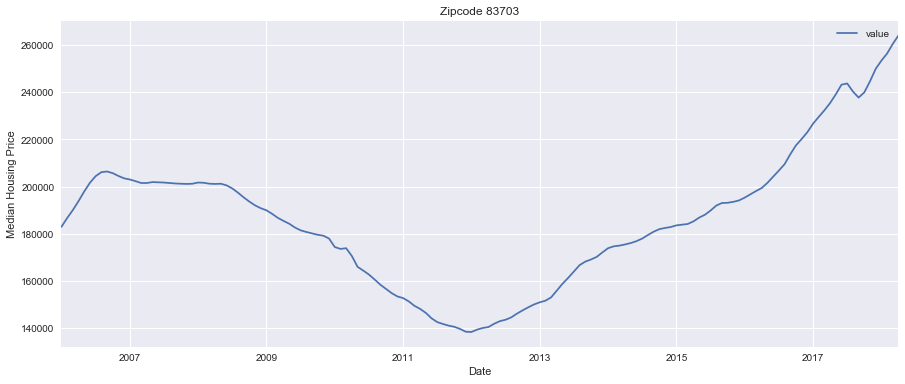

In [78]:
BlogData.plot()
plt.title('Zipcode 83703');
plt.xlabel('Date');
plt.ylabel('Median Housing Price');

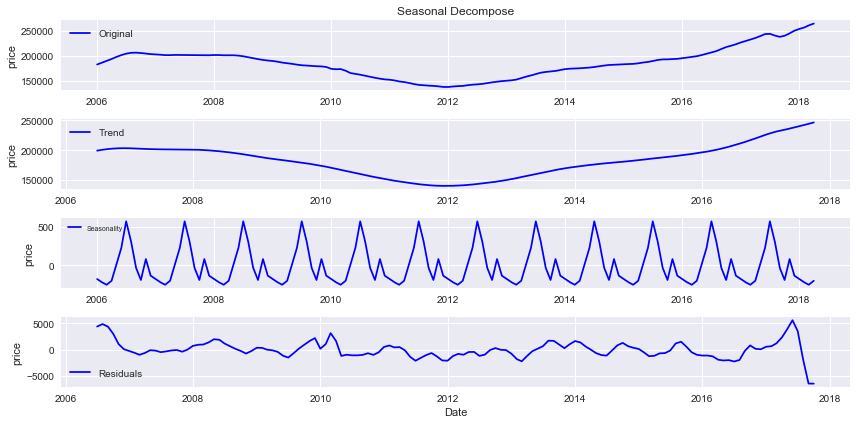

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Taking the decomposition
decomposition = seasonal_decompose(BlogData)

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(Idaho_25_dict['83703'], label='Original', color='blue')
plt.legend(loc='best')
plt.title('Seasonal Decompose')
plt.ylabel('price')
plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.ylabel('price')
plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left', fontsize='x-small')
plt.ylabel('price')
plt.subplot(4,1,4)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.ylabel('price')
plt.xlabel('Date')
plt.tight_layout()

The time difference between the two minimums is 365 days 00:00:00


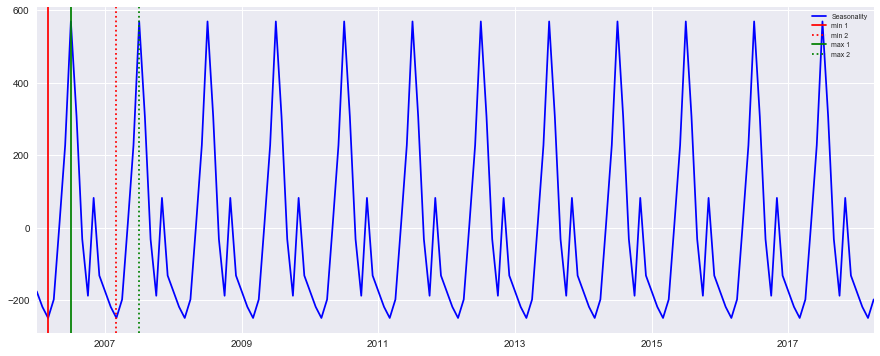

In [110]:
ax = seasonal.plot(label='Seasonality', color='blue')

min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')

print(f'The time difference between the two minimums is {min_2-min_}')

In [114]:
train, test = train_test_split(BlogData, train_size=120)

auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12,
                           max_order=None,trace=True)

display(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1905.296, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1909.042, Time=0.32 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1909.041, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1907.291, Time=0.09 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1909.519, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1910.586, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1907.080, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1907.076, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1908.770, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1907.158, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.703 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -951.648
Date:                Sun, 11 Apr 2021   AIC                           1905.296
Time:                        21:41:21   BIC                           1908.067
Sample:                             0   HQIC                          1906.421
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.921e+05   3.84e+04     15.417      0.000    5.17e+05    6.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               180.10
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.18
Prob(H) (two-sided):                  0.68   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""